In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

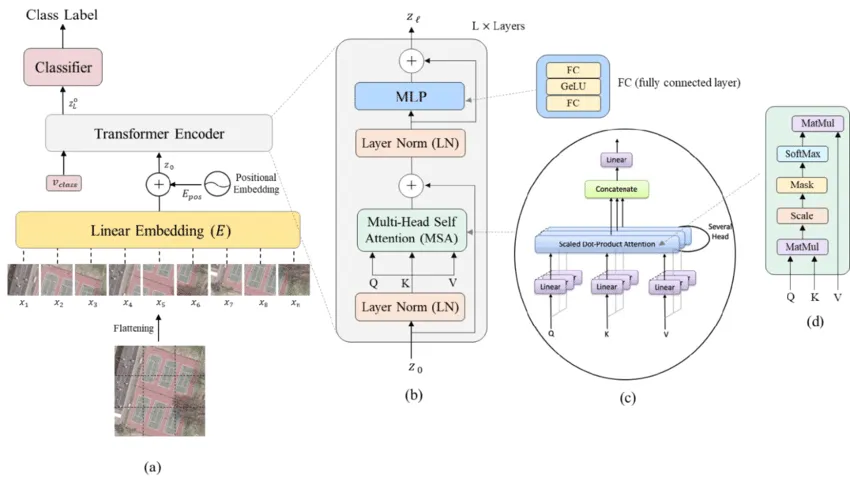

### Pachify  
for example : a batch of square images(7, 1, 28, 28) would be patchify to (7, patch\*\*2, h\*w\*c / patch\*\*2)  
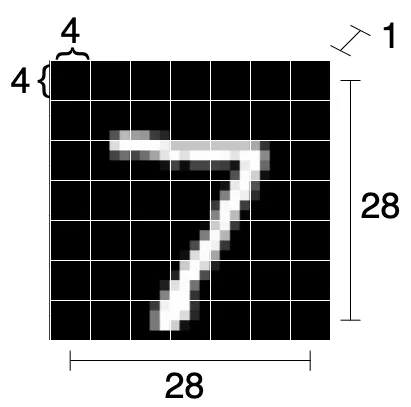

In [7]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

declare a ViT module

In [ ]:
class MyViT(nn.Module):
    def __init__(self):
        # Super constructor
        super(MyViT, self).__init__()

    def forward(self, images):
        pass

add patchify function

In [9]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    return patches

We can test the functioning of our class with a simple program

In [10]:
# Current model
model = MyViT(
  chw=(1, 28, 28),
  n_patches=7
)

x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([7, 49, 16])


since we already have patchified vectors, we can compress it by using a fully-connection layer.

In [13]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = self.patch_size[0] * self.patch_size[1]
    self.hidden_d = 8
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)
    return tokens

In [14]:
# Current model
model = MyViT(
  chw=(1, 28, 28),
  n_patches=7
)

x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x).shape) # torch.Size([7, 49, 8])

torch.Size([7, 49, 8])


add class token  
the classification token is put as the first token of each sequence  
class token capture features frome other tokens  
then we can classify images with only this token

In [16]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = self.patch_size[0] * self.patch_size[1]
    self.hidden_d = 8

    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
    return tokens

In [17]:
# Current model
model = MyViT(
  chw=(1, 28, 28),
  n_patches=7
)

x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x).shape) # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


Positional encoding

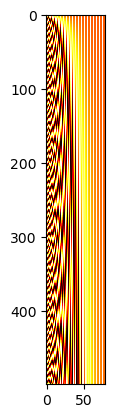

In [20]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(500, 80), cmap="hot", interpolation="nearest")
  plt.show()

In [27]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.hidden_d = 8
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    # self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    # self.pos_embed.requires_grad = False
    self.pos_embed = get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d).detach()

  def forward(self, images):
    patches = patchify(images, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Adding positional embedding
    batch = tokens.shape[0]
    pos_embed = self.pos_embed.repeat(batch, 1, 1)
    out = tokens + pos_embed
    return out


In [28]:
# Current model
model = MyViT(
  chw=(1, 28, 28),
  n_patches=7
)

x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x).shape) # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


define a multi-head self attention module

In [46]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
MyMSA(8)


MyMSA(
  (q_mappings): ModuleList(
    (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
  )
  (k_mappings): ModuleList(
    (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
  )
  (v_mappings): ModuleList(
    (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=-1)
)

Vit encoder

In [47]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])


torch.Size([7, 50, 8])


integrate to completed model

In [48]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out


add classification head

In [59]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

if __name__ == '__main__':
    model = MyViT(chw=(1,28,28))

    x = torch.randn(7, 1, 28, 28)  # Dummy sequences
    print(model(x).shape)


torch.Size([7, 10])


In [63]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

if __name__ == '__main__':
    main()

100%|██████████| 9912422/9912422 [00:00<00:00, 30899569.94it/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 225999428.78it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:01<00:00, 1051046.69it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14722201.52it/s]


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

Using device:  cuda (NVIDIA GeForce RTX 2070 SUPER)


Training:  20%|██        | 1/5 [03:47<15:09, 227.39s/it]

Epoch 1/5 loss: 2.12


Training:  40%|████      | 2/5 [07:34<11:21, 227.24s/it]

Epoch 2/5 loss: 1.96


Training:  60%|██████    | 3/5 [11:22<07:34, 227.40s/it]

Epoch 3/5 loss: 1.89


Training:  80%|████████  | 4/5 [15:09<03:47, 227.46s/it]

Epoch 4/5 loss: 1.85


Training: 100%|██████████| 5/5 [18:57<00:00, 227.52s/it]


Epoch 5/5 loss: 1.81


Testing: 100%|██████████| 79/79 [00:23<00:00,  3.34it/s]

Test loss: 1.79
Test accuracy: 67.00%
